In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import sklearn.metrics as metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/Users/trieuhoanghiep/Documents/Me/Project/Deloitte/train.csv")

Preprocessing

In [4]:
# Change the names of the columns Employment Duration, Home Ownership and Debit to Income Ratio
df.rename(columns={'Employment Duration': 'Home Ownership', 'Home Ownership': 'Employment Duration', 'Debit to Income':'Debt to Income'}, inplace=True)

In [5]:
# Remove space in the columns
df.columns = df.columns.str.replace('-','')
df.columns = df.columns.str.replace(' ','_')

In [6]:
df['Available_Accounts'] = df['Total_Accounts'] - df['Open_Account']

In [7]:
# 1. Remove columns that don't value to the analysis
df.drop(['ID','Accounts_Delinquent','Payment_Plan','Sub_Grade','Total_Accounts','Open_Account'],axis=1, inplace=True)

In [8]:
## 2. Remove variables that are generated upon post approval of the loan. 
# Since, we have to predict if a loan applicant will default on a loan or not, including features generated after loan approval will cause data leakage. 
# It will further lead to overfitting and the model may not work well with the test dataset. Therefore, these variables will be removed.
df.drop(['Delinquency__two_years','Revolving_Balance','Revolving_Utilities','Total_Received_Interest','Total_Received_Late_Fee','Recoveries','Collection_Recovery_Fee',
'Collection_12_months_Medical','Last_week_Pay','Total_Revolving_Credit_Limit','Total_Collection_Amount','Total_Current_Balance'],axis=1, inplace=True)

In [9]:
df['Available_Accounts'] = abs(df['Available_Accounts'])

In [10]:
# Create new columns for Loan Amount and Funded Amount Investor
df['Actual_Loan_Amount'] = df['Loan_Amount']
df['Actual_Funded_Amount_Investor'] = df['Funded_Amount_Investor']

# Calculate the maximum value of the three columns for Loan Amount
df['Actual_Loan_Amount'] = df[['Loan_Amount','Funded_Amount','Funded_Amount_Investor']].max(axis=1)

# Calculate the minimum value of the three columns for Funded Amount Investor
df['Actual_Funded_Amount_Investor'] = df[['Loan_Amount','Funded_Amount','Funded_Amount_Investor']].min(axis=1)
# Loan Amount, Funded Amount and Funded Amount Investor are all dropped. 
df.drop(['Loan_Amount','Funded_Amount','Funded_Amount_Investor'], axis=1, inplace = True)

In [11]:
# Correct the labels in Verification Status
dict = {'Source Verified': 'Verified','Verified':'Verified','Not Verified':'Not Verified'}
df['Verification_Status'].replace(dict, inplace = True)

In [12]:
# Correct the labels in Loan Title
title_dict = {'Debt Consolidation 2013': 'debt_consolidation','Debt Reduction':'debt_consolidation','Debt':'debt_consolidation','conso':'debt_consolidation',
'debt loan': 'debt_consolidation','get out of debt':'debt_consolidation','Consolidated':'debt_consolidation','Debt Payoff':'debt_consolidation',
'Loan Consolidation': 'debt_consolidation','relief':'debt_consolidation','Lending Club':'debt_consolidation','Debt Loan':'debt_consolidation',
'CONSOLIDATION': 'debt_consolidation','Get Debt Free':'debt_consolidation','Freedom':'debt_consolidation','consolidation':'debt_consolidation','Lending loan':'debt_consolidation',
'Debt Free': 'debt_consolidation','Debt Consolidation Loan':'debt_consolidation','Debt payoff':'debt_consolidation','debt consolidation loan':'debt_consolidation',
'Consolidation': 'debt_consolidation','Debt Consolidation':'debt_consolidation','Debt consolidation':'debt_consolidation','CONSOLIDATE':'debt_consolidation',
'DEBT CONSOLIDATION': 'debt_consolidation','Consolidation Loan':'debt_consolidation','consolidation loan':'debt_consolidation','debt consolidation':'debt_consolidation',
'consolidate': 'debt_consolidation','Consolidate':'debt_consolidation','debt':'debt_consolidation','Credit Card':'credit_card','Credit Card consolidation':'credit_card',
'Dept consolidation':'debt_consolidation','CC Refi': 'credit_card','pay off bills':'credit_card','CC-Refinance':'credit_card','Refinance Loan':'credit_card',
'bills': 'credit_card','Credit':'credit_card','Credit Card Paydown':'credit_card','Credit Card Refinance Loan':'credit_card',
'credit pay off': 'credit_card','Credit card refinancing':'credit_card','CC Loan':'credit_card','credit card refinance':'credit_card',
'Credit Card Loan': 'credit_card','Credit Card Consolidation':'credit_card','Card Consolidation':'credit_card','CC consolidation':'credit_card',
'Bill Payoff': 'credit_card','Credit Consolidation':'credit_card','credit card consolidation':'credit_card','Refinance':'credit_card',
'refi':'credit_card','Credit Card Debt':'credit_card','Credit card payoff':'credit_card','Credit Card Refinance':'credit_card','CC Consolidation':'credit_card',
'payoff':'credit_card','Credit Cards':'credit_card','CC Refinance':'credit_card','Credit card pay off':'credit_card','cards':'credit_card',
'credit card':'credit_card','Credit Card Refi':'credit_card','Cards':'credit_card','Pay Off':'credit_card',
'Credit Loan':'credit_card','Credit Card Payoff':'credit_card','CC':'credit_card','Payoff':'credit_card',
'Credit card refinance':'credit_card','Bill Consolidation':'credit_card','Credit payoff':'credit_card','Home improvement':'BuyingHouse&HomeImprovement',
'Home Improvement':'BuyingHouse&HomeImprovement','Home Improvement Loan':'BuyingHouse&HomeImprovement','home improvement':'BuyingHouse&HomeImprovement','Pool':'BuyingHouse&HomeImprovement',
'Home buying':'BuyingHouse&HomeImprovement','House':'BuyingHouse&HomeImprovement','Home':'BuyingHouse&HomeImprovement','Bathroom':'BuyingHouse&HomeImprovement',
'Home loan':'BuyingHouse&HomeImprovement','Getting Ahead': 'BuyingHouse&HomeImprovement','Moving and relocation':'moving','other':'Other','vacation':'vacation',
'Vacation':'vacation','Wedding Loan':'wedding','MYLOAN':'personal','Personal':'personal',
'Personal Loan': 'personal','loan1':'personal','Loan 1':'personal','My Loan':'personal',
'Loan': 'personal','Personal loan':'personal','Major purchase':'major_purchase','Medical expenses':'medical',
'Medical loan': 'medical','Medical':'medical','Car Loan':'car','Car financing':'car',
'car':'car','Business': 'business','Green loan':'renewable_energy'}
df['Loan_Title'].replace(title_dict, inplace = True)

One hot encoder

In [13]:
# Create an instance of One-hot-encoder 
enc = OneHotEncoder() 
  
# Passing encoded columns 
  
enc_data = pd.DataFrame(enc.fit_transform( 
    df[['Grade','Home_Ownership','Verification_Status','Initial_List_Status','Application_Type','Loan_Title']]).toarray()) 

enc.get_feature_names_out ()
enc_data.columns = enc.get_feature_names_out ()
  
# Merge with main 
New_df = df.join(enc_data) 
New_df.drop(['Grade','Home_Ownership','Verification_Status','Initial_List_Status','Application_Type','Loan_Title', 'Batch_Enrolled'],axis=1,inplace=True)
New_df

Term  Interest_Rate  Employment_Duration  Debt_to_Income  \
0        59      11.135007         176346.62670       16.284758   
1        59      12.237563          39833.92100       15.412409   
2        59      12.545884          91506.69105       28.137619   
3        59      16.731201         108286.57590       18.043730   
4        59      15.008300          44234.82545       17.209886   
...     ...            ...                  ...             ...   
67458    59       9.408858          83961.15003       28.105127   
67459    59       9.972104          65491.12817       17.694279   
67460    59      19.650943          34813.96985       10.295774   
67461    59      13.169095          96938.83564        7.614624   
67462    59      16.034631         105123.15580       16.052112   

       Inquires__six_months  Public_Record  Loan_Status  Available_Accounts  \
0                         0              0            0                   6   
1                         0              0            0                   1   
2                         0              0            0                   6   
3                         0              0            0                   5   
4                         3              1            0                   9   
...                     ...            ...          ...                 ...   
67458                     0              0            1                   6   
67459                     0              0            0                   2   
67460                     0              1            0                   2   
67461                     0              0            0                   1   
67462                     0              0            0                  14   

       Actual_Loan_Amount  Actual_Funded_Amount_Investor  ...  Loan_Title_car  \
0             32236.00000                    10000.00000  ...             0.0   
1             12191.99692                     3609.00000  ...             0.0   
2             28276.00000                     9311.00000  ...             0.0   
3             17877.15585                     6954.00000  ...             0.0   
4             16890.00000                    13226.00000  ...             0.0   
...                   ...                            ...  ...             ...   
67458         13601.00000                     6848.00000  ...             0.0   
67459         15637.46301                     8323.00000  ...             0.0   
67460         32921.00000                    12329.45775  ...             0.0   
67461         21353.68465                     4975.00000  ...             0.0   
67462         29875.00000                    14207.44860  ...             0.0   

       Loan_Title_credit_card  Loan_Title_debt_consolidation  \
0                         0.0                            1.0   
1                         0.0                            1.0   
2                         0.0                            1.0   
3                         0.0                            1.0   
4                         1.0                            0.0   
...                       ...                            ...   
67458                     1.0                            0.0   
67459                     1.0                            0.0   
67460                     0.0                            1.0   
67461                     0.0                            1.0   
67462                     0.0                            1.0   

       Loan_Title_major_purchase  Loan_Title_medical  Loan_Title_moving  \
0                            0.0                 0.0                0.0   
1                            0.0                 0.0                0.0   
2                            0.0                 0.0                0.0   
3                            0.0                 0.0                0.0   
4                            0.0                 0.0                0.0   
...                          ...                 ...         

In [14]:
corr = New_df.corr(method = 'pearson').abs()
plt.figure(figsize=(20,20), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5,vmin=-1,cmap='coolwarm')
plt.show()

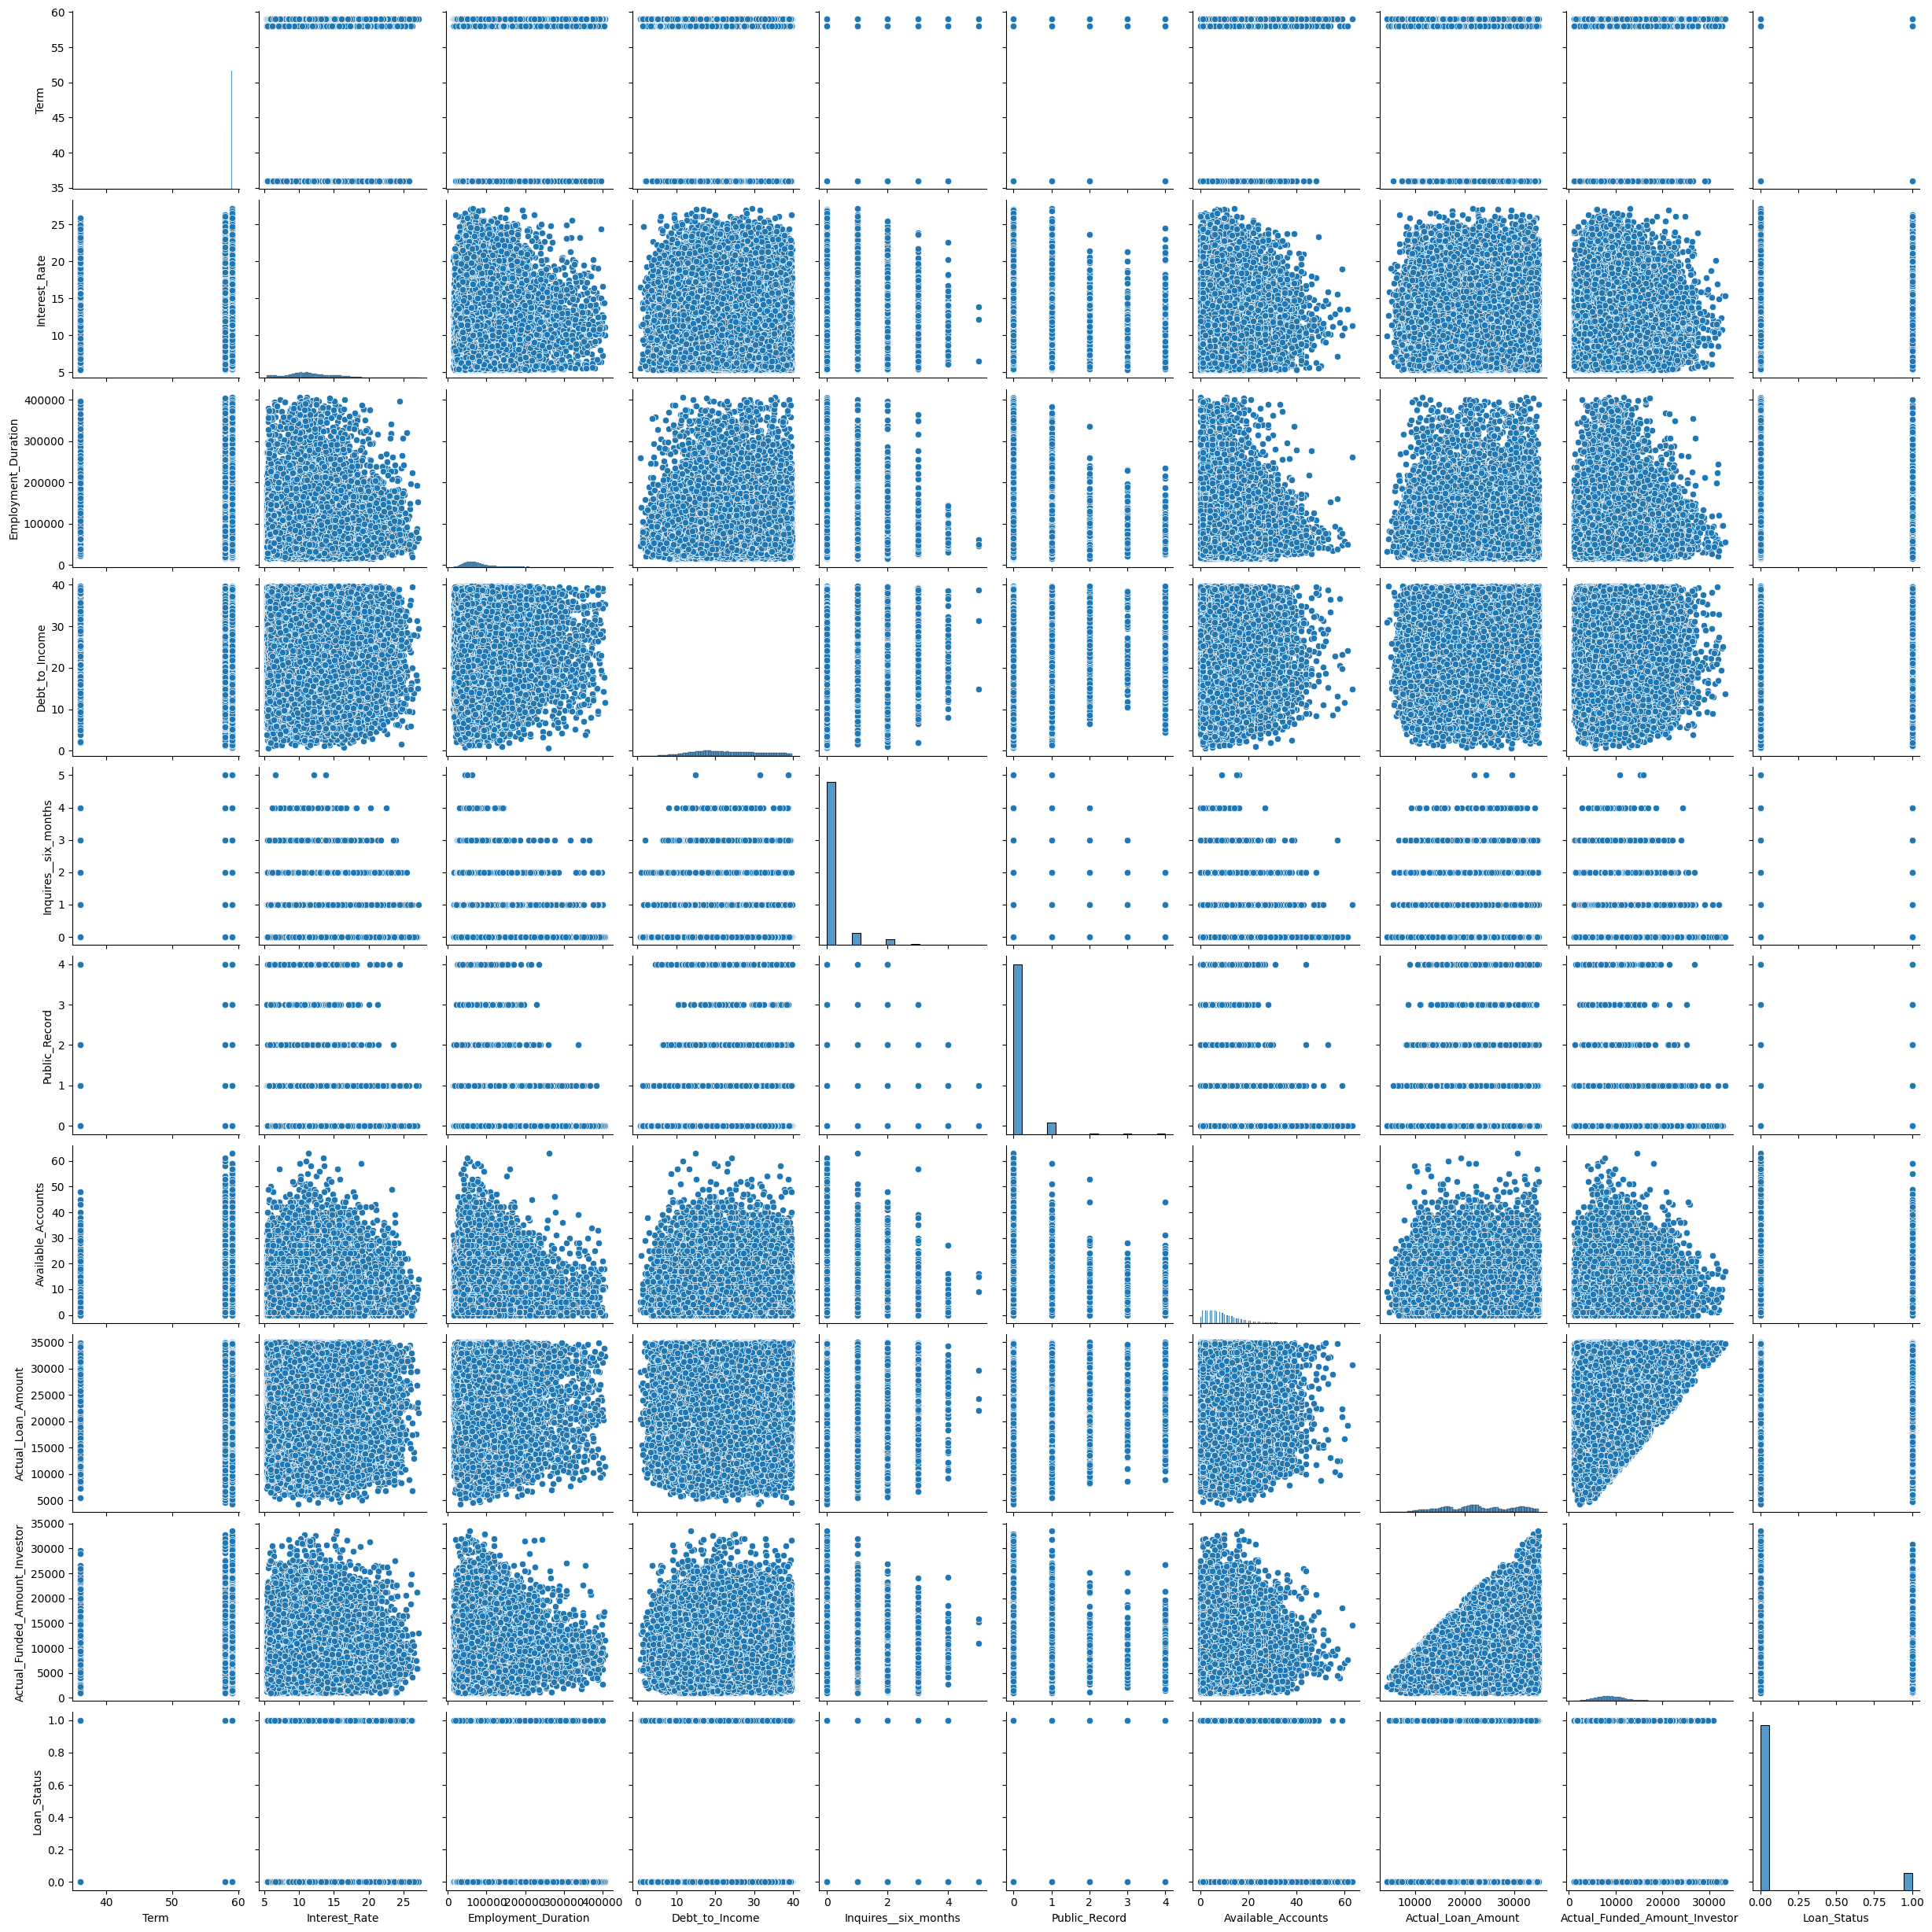

In [15]:
df_1 = df[['Term','Interest_Rate','Employment_Duration','Debt_to_Income','Inquires__six_months','Public_Record',
'Available_Accounts','Actual_Loan_Amount','Actual_Funded_Amount_Investor','Loan_Status']]
sns.pairplot(df_1)

Train test split

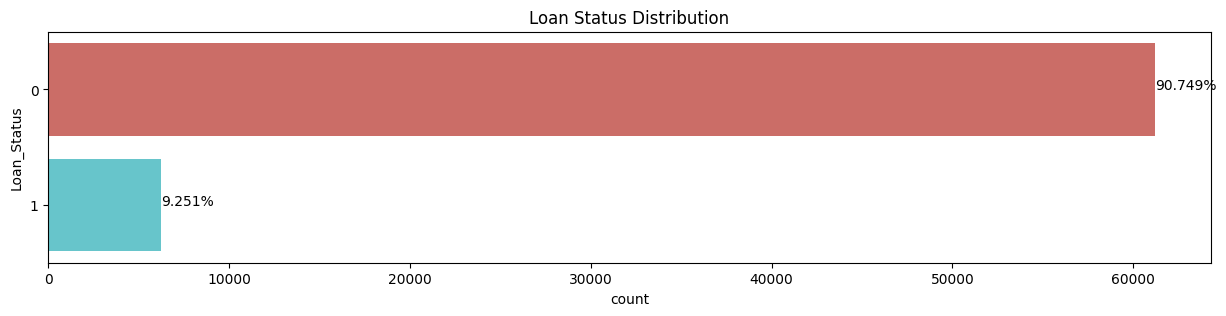

In [16]:
## Overall distribution of Loan Status

#Countplot of loan status
plt.figure(figsize=(15,3))
ax=sns.countplot(y='Loan_Status',data=df, palette='hls',order = New_df['Loan_Status'].value_counts().index)
plt.title('Loan Status Distribution')
total = len(New_df['Loan_Status'])
for p in ax.patches:
        percentage = '{:.3f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [17]:
X = New_df.drop(['Loan_Status'], axis=1)
y = New_df['Loan_Status']

In [18]:
#split data into training and test data (70% versus 30%)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=4,stratify=y) 

In [19]:
from sklearn.preprocessing import StandardScaler
# List for columns to scale
cols_to_scale = ['Term','Interest_Rate','Employment_Duration','Debt_to_Income','Inquires__six_months','Public_Record',
'Available_Accounts','Actual_Loan_Amount','Actual_Funded_Amount_Investor']

# Create scaler
scaler = StandardScaler()

# Create a copy of the datasets
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale selected data
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [20]:
#further split traning data into training and validation data (70% versus 30%)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=4,stratify=y_train)

Catboost

In [21]:
from catboost import Pool, CatBoostClassifier

In [22]:
train = Pool(X_train_new,y_train_new)
test = Pool(X_val,y_val)

In [69]:
import itertools
learning_rate = [0.0005,0.0006,0.0007,0.0008,0.0009,0.001]# the recommended value is from 0.001-0.1 
depth = [6,7,8,9,10,]# the recommended value is from 4-10 so the value is set with step of 2
l2_leaf_reg = [0.0,1.0,2.0,3.0,4.0] # the recommended value is from 2-10 so the value is set with step of 2
random_strength = [0] # the recommended value is from 0-10 so the value is set with step of 2
colsample_bylevel = [0.5] # the range of parameter is from 0.5-1 so the value is set with step of 0.25
#create a list of parameters
per = [learning_rate,depth,l2_leaf_reg,random_strength,colsample_bylevel]
param = list(itertools.product(*per))
len(param)

150

In [70]:
result = []
df_result_catboost_2 = pd.DataFrame(columns=['learning_rate','depth','l2_leaf_reg','random_strength','colsample_bylevel','result_train','result_valid'])
for learning_rate,depth,l2_leaf_reg,random_strength,colsample_bylevel in param:
    train_data = Pool(X_train_new,y_train_new)
    valid_data = Pool(X_val,y_val)
    eval_set = [train_data, valid_data]
    cat = CatBoostClassifier(learning_rate=learning_rate,depth=depth,l2_leaf_reg=l2_leaf_reg
                       ,random_strength=random_strength
                       ,random_state=0,verbose=False,early_stopping_rounds=20,colsample_bylevel=colsample_bylevel
                       ,eval_metric='AUC',use_best_model = True,scale_pos_weight=9,n_estimators=100)
    cat.fit(X = X_train_new, y = y_train_new,eval_set=eval_set)
    y_pred_train = cat.predict(X_train_new)
    y_pred_valid = cat.predict(X_val)
    result_train = metrics.roc_auc_score(y_train_new,y_pred_train)*100
    result_valid = metrics.roc_auc_score(y_val,y_pred_valid)*100
    temp_result = [learning_rate,depth,l2_leaf_reg,random_strength,colsample_bylevel,result_train,result_valid]
    print(temp_result)
    result.append(temp_result)
    df_result_catboost_2.loc[len(df_result_catboost_2)] = temp_result

[0.0005, 6, 0.0, 0, 0.5, 53.65824825924667, 50.13191553528249]
[0.0005, 6, 1.0, 0, 0.5, 53.64528448004576, 50.18218830612805]
[0.0005, 6, 2.0, 0, 0.5, 53.64139534628548, 50.1761386993525]
[0.0005, 6, 3.0, 0, 0.5, 53.38405641636251, 50.62641254727937]
[0.0005, 6, 4.0, 0, 0.5, 53.38405641636251, 50.62641254727937]
[0.0005, 7, 0.0, 0, 0.5, 52.93451923910555, 50.45836093354229]
[0.0005, 7, 1.0, 0, 0.5, 52.933222861185456, 50.45836093354229]
[0.0005, 7, 2.0, 0, 0.5, 52.92933372742519, 50.449286523378944]
[0.0005, 7, 3.0, 0, 0.5, 52.92414821574483, 50.44626171999117]
[0.0005, 7, 4.0, 0, 0.5, 52.92285183782474, 50.44626171999117]
[0.0005, 8, 0.0, 0, 0.5, 56.1095887865499, 51.741478940367394]
[0.0005, 8, 1.0, 0, 0.5, 56.17526720881024, 51.83899967867074]
[0.0005, 8, 2.0, 0, 0.5, 58.780141479010794, 50.993562643947435]
[0.0005, 8, 3.0, 0, 0.5, 58.85649688564657, 50.8424750610795]
[0.0005, 8, 4.0, 0, 0.5, 58.723712772556205, 50.70750779537608]
[0.0005, 9, 0.0, 0, 0.5, 61.45250323191104, 50.81142

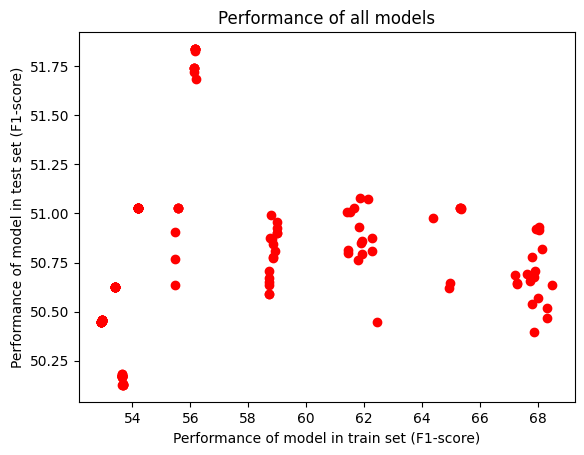

In [71]:
#visulize performance of all models
result_catboost_a = sorted(result,key=lambda x: x[-1],reverse=True)
result_catboost_b = [i[-2:] for i in result_catboost_a]
for x in range(len(result_catboost_b)):
    plt.plot(result_catboost_b[x][0],result_catboost_b[x][1],'ro-')
    plt.xlabel('Performance of model in train set (F1-score)')
    plt.ylabel('Performance of model in test set (F1-score)')
    plt.title('Performance of all models')

In [72]:
#sort all set of parameters based on the performance on the test set
df_result_catboost_2.sort_values('result_valid',ascending=False)

learning_rate  depth  l2_leaf_reg  random_strength  colsample_bylevel  \
11          0.0005    8.0          1.0              0.0                0.5   
61          0.0007    8.0          1.0              0.0                0.5   
111         0.0009    8.0          1.0              0.0                0.5   
136         0.0010    8.0          1.0              0.0                0.5   
86          0.0008    8.0          1.0              0.0                0.5   
..             ...    ...          ...              ...                ...   
25          0.0006    6.0          0.0              0.0                0.5   
125         0.0010    6.0          0.0              0.0                0.5   
100         0.0009    6.0          0.0              0.0                0.5   
50          0.0007    6.0          0.0              0.0                0.5   
75          0.0008    6.0          0.0              0.0                0.5   

     result_train  result_valid  
11      56.175267     51.839000  
61      56.175267     51.839000  
111     56.175267     51.839000  
136     56.175267     51.839000  
86      56.175267     51.839000  
..            ...           ...  
25      53.656952     50.128891  
125     53.654359     50.125866  
100     53.655656     50.125866  
50      53.656952     50.125866  
75      53.655656     50.125866  

[150 rows x 7 columns]

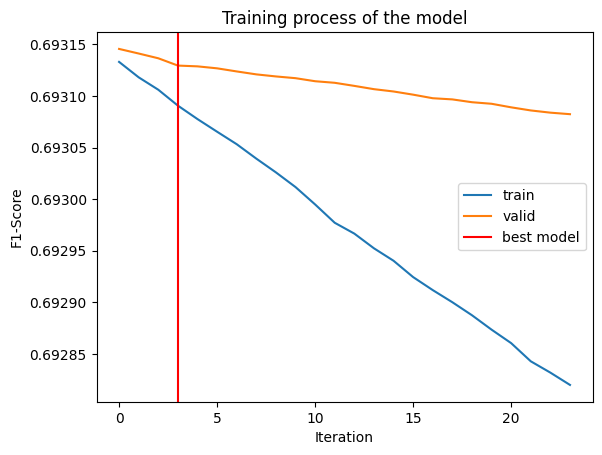

In [73]:
#build the best catboost based on performance of the test set
cat = CatBoostClassifier(learning_rate=0.0005,depth=8,l2_leaf_reg=1.0
                       ,random_strength=0
                       ,random_state=0,verbose=False,early_stopping_rounds=20,colsample_bylevel=0.5
                       ,eval_metric='AUC',use_best_model = True,scale_pos_weight=9)
train_data = Pool(X_train_new,y_train_new)
valid_data = Pool(X_val,y_val)
eval_set = [train_data, valid_data]
cat.fit(X = X_train_new, y = y_train_new,eval_set=eval_set)

#visulise the training process
evals_result = cat.get_evals_result()
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation_1']['Logloss']
plt.plot(train_loss,label='train')
plt.plot(test_loss,label='valid')
plt.title('Training process of the model')
plt.xlabel('Iteration')
plt.ylabel('F1-Score')
plt.axvline(x=cat.get_best_iteration(), color = 'r', linestyle = '-',label = 'best model') 
plt.legend()

In [74]:
#visualise tree
cat.plot_tree(tree_idx=0,pool=valid_data)

In [75]:
from sklearn.metrics import confusion_matrix,classification_report
#predict output
y_pred_train = cat.predict(X_train_new)
y_pred_valid = cat.predict(X_val)
y_pred_proba = cat.predict_proba(X_val)[:,1]
#evaluation
print('Confusion matrix')
print(confusion_matrix(y_val, y_pred_valid))

print('F1 score train', metrics.f1_score(y_train_new,y_pred_train))
print('F1 score test', metrics.f1_score(y_val,y_pred_valid))
print(classification_report(y_val, y_pred_valid))

Confusion matrix
[[13469  3061]
 [ 1311   374]]
F1 score train 0.19786453119786454
F1 score test 0.14609375
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     16530
           1       0.11      0.22      0.15      1685

    accuracy                           0.76     18215
   macro avg       0.51      0.52      0.50     18215
weighted avg       0.84      0.76      0.79     18215



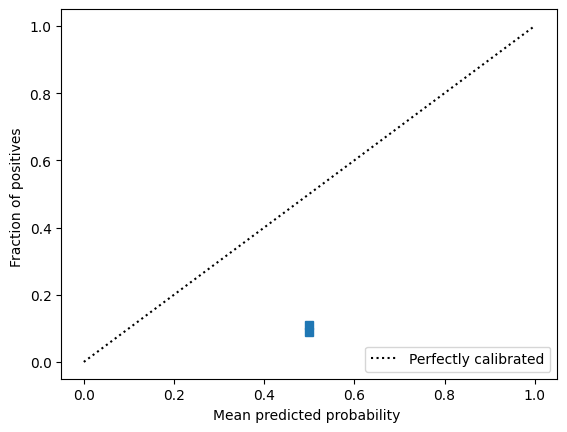

In [76]:
from sklearn.calibration import calibration_curve,CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
disp.plot()

<Axes: ylabel='Count'>

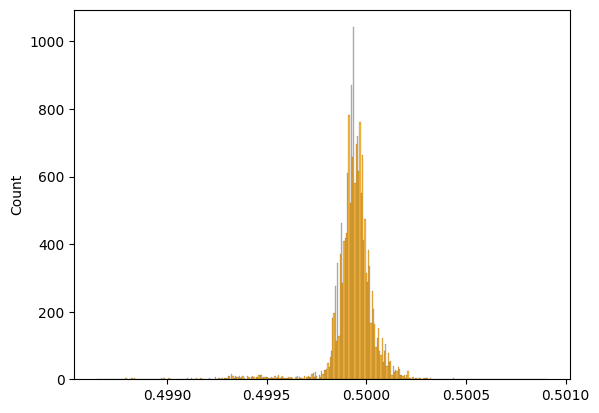

In [77]:
sns.histplot(y_pred_proba, color='orange')

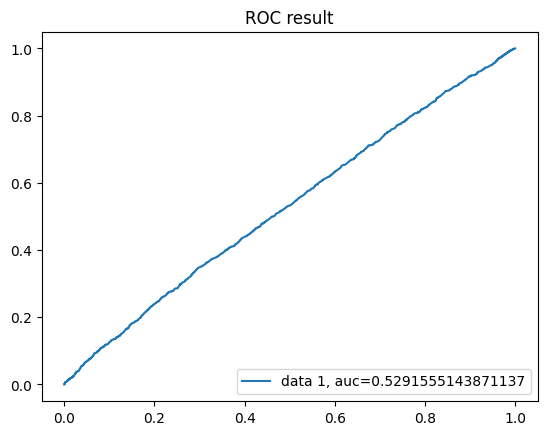

In [80]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('ROC result')
plt.legend(loc=4)
plt.show()

<Axes: >

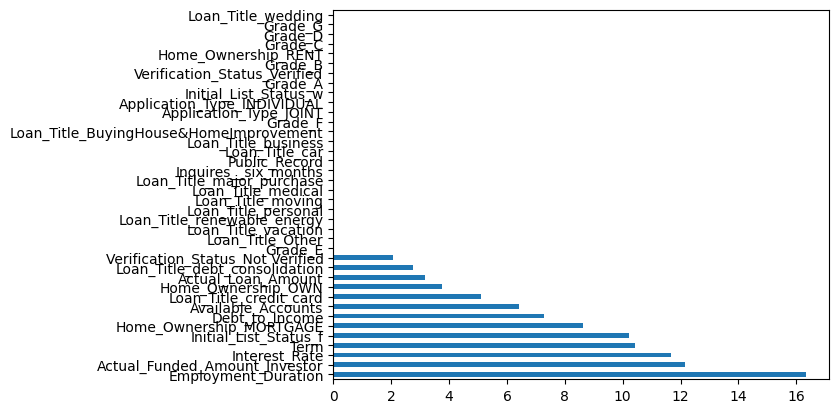

In [79]:
feat_importances = pd.Series(cat.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(40).plot(kind='barh')